# Biometter-Classification
생물 분자간의 충돌 시뮬레이션 분석  
CNN 사용

In [10]:
# CopyRight kairos03 2017. All Right Reserved.

## model-es.py

import tensorflow as tf
import time
from data import input_data
import numpy as np

## Hyper Parameter
하이퍼파라미터 설정

In [9]:
# hyper parameter
learning_rate = 1e-3
total_epoch = 100
batch_size = 30
dropout_keep_prob = 0.9

## Log path 
로그 저장 위치 지정

In [12]:
# name, log, model path setting
name = 'lr_{}_epoch_{}_batch_{}_{}'.format(learning_rate, total_epoch, batch_size, time.time())
log_root = './log/' + name + '/'
model_root = './model/' + name + '/'

## Basic Layer
기본 기능을 포함하는 베이직레이어 생성 추후 상속 받아 사용

In [14]:
class BasicLayer:
    def var_summary(self, name, var):
        with tf.name_scope(name):
            mean = tf.reduce_mean(var)
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            tf.summary.scalar('stddev', stddev)
            tf.summary.scalar('mean', mean)
            tf.summary.histogram('histogram', var)

    def var_weight(self, shape, stddev=0.1):
        var = tf.truncated_normal(shape, stddev=stddev)
        self.var_summary('W', var)
        return tf.Variable(var)

    def var_bias(self, shape):
        var = tf.constant(0.1, shape=shape)
        self.var_summary('B', var)
        return tf.Variable(var)


## Convolution Layer
Conv2d 레이어 클래스

In [15]:
class Conv2dLayer(BasicLayer):
    def __init__(self, input, filter_size, strides, padding, activation=tf.nn.relu):
        self.input = input
        self.filter_size = filter_size
        self.strides = strides
        self.padding = padding
        self.activation = activation

    def make_layer(self):
        filter = self.var_weight(self.filter_size)
        conv = tf.nn.conv2d(self.input, filter, strides=self.strides, padding=self.padding)
        conv = self.activation(conv)
        tf.summary.histogram('act', conv)
        return conv

## Fully Connected Layer
모델의 마지막단에 사용할 FC Layer 클래스

In [16]:
class FullConnectedLayer(BasicLayer):
    def __init__(self, input, input_dim, output_dim, activation=tf.nn.relu):
        self.input = input
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation = activation

    def make_layer(self):
        weight = self.var_weight([self.input_dim, self.output_dim])
        bias = self.var_bias([self.output_dim])
        fc = tf.matmul(self.input, weight) + bias
        fc = self.activation(fc)
        tf.summary.histogram('act', fc)
        return fc

## CNN Model 정의
- input은 640x512x2의 파일로 흑백의 앞, 오른쪽 이미지 두장을 같이 넘김
- Convolution Layer 3개, MaxPool 2개, FullyConnected Layer 2개로 구성
- 마지막 FC에 dropout 적용
- 모든 Layer의 Activation 함수는 ReLU
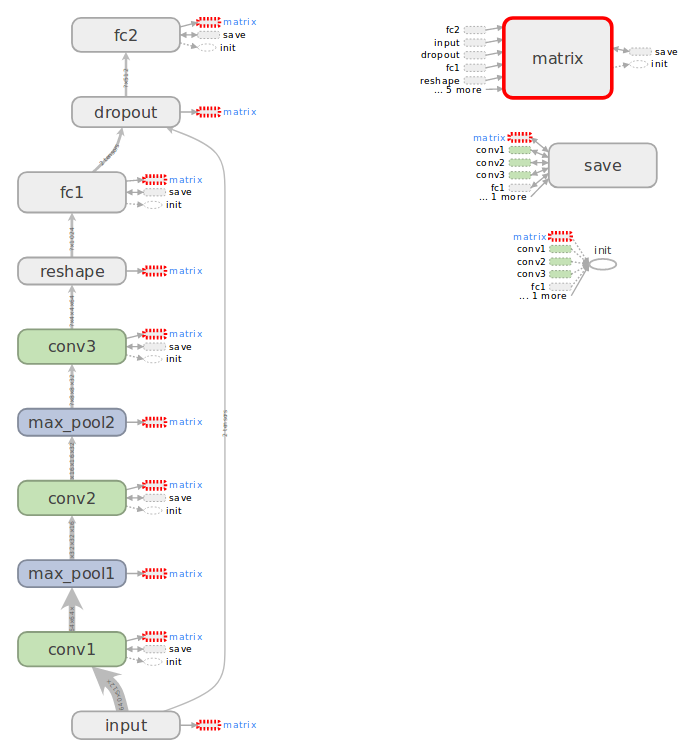

In [2]:
def make_model(X, Y, keep_prob):
    """make model
        Args:
            X: input image place holder
            Y: input label place holder
            keep_prob: drop out parameter place holder
        Returns:
            model: predict model
            xent: cross entropy operation
            optimizer: optimizer operation
            accuracy: accuracy operation
    """
    # layers
    with tf.name_scope('conv1'):
        conv1 = Conv2dLayer(X, [10, 10, 2, 16], strides=[1, 10, 8, 1], padding='SAME').make_layer()

    with tf.name_scope('max_pool1'):
        pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    with tf.name_scope('conv2'):
        conv2 = Conv2dLayer(pool1, [3, 3, 16, 32], strides=[1, 2, 2, 1], padding='SAME').make_layer()

    with tf.name_scope('max_pool2'):
        pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    with tf.name_scope('conv3'):
        conv3 = Conv2dLayer(pool2, [3, 3, 32, 64], strides=[1, 2, 2, 1], padding='SAME').make_layer()

    with tf.name_scope('reshape'):
        reshaped = tf.reshape(conv3, [-1, 4 * 4 * 64])

    with tf.name_scope('fc1'):
        fc1 = FullConnectedLayer(reshaped, 4 * 4 * 64, 512).make_layer()

    with tf.name_scope('dropout'):
        droped = tf.nn.dropout(fc1, keep_prob)

    with tf.name_scope('fc2'):
        model = FullConnectedLayer(droped, 512, 2, activation=tf.identity).make_layer()

    # matrix define
    with tf.name_scope('matrix'):
        xent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=Y), name='xent')
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(xent)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(model, 1), tf.argmax(Y, 1)), tf.float32), 
                                  name='accuracy')

        tf.summary.scalar('accuracy', accuracy)
        tf.summary.scalar('xent', xent)

    return model, xent, optimizer, accuracy

## Train phase
- adam optimizer 사용
- 매 5회마다 테스트를 수행하여 중간체크
- 트레이닝이 끝난후 전체 데이터를 이용하여 테스트 진행

In [4]:
def do_train(validation_epoch):
    """train
        Args:
            validation_epoch: validation epoch to train step
        Return:
            acc: final test accuracy
    """
    with tf.Graph().as_default() as train_g:
        # input
        with tf.name_scope('input'):
            X = tf.placeholder(tf.float32, [None, 640, 512, 2], name='X')
            Y = tf.placeholder(tf.float32, [None, 2], name='Y')
            keep_prob = tf.placeholder(tf.float32)

        # get model and op
        model, xent, optimizer, accuracy = make_model(X, Y, keep_prob)

        # data load
        train_data, test_data = input_data.read_cross_validation_data_set(validation_epoch)

        # summary setting
        merged = tf.summary.merge_all()
        saver = tf.train.Saver()

        def next_batch(batch, is_train=True, one_hot=True):
            """ get next batch
                Args:
                    batch: current batch iteration, int
                    is_train: if False return Test data, default True
                    one_hot: if True return one hot encoded data, default True
                Returns:
                    xs: image data
                    ys: label data
            """
            # select data
            if is_train:
                xs = train_data['image'][:(batch + 1) * batch_size]
                ys = train_data['is_contacted'][:(batch + 1) * batch_size]

            else:
                xs = train_data['image'][:]
                ys = train_data['is_contacted'][:]

            # reform data
            ys = np.array(ys)

            # one hot encoding
            if one_hot:
                ys = np.array(ys).reshape(-1).astype(int)
                ys = np.eye(2)[ys]

            return xs, ys

        # train session
        with tf.Session() as sess:
            train_log = tf.summary.FileWriter(log_root + 'train{}'.format(validation_epoch), sess.graph)
            test_log = tf.summary.FileWriter(log_root + 'test{}'.format(validation_epoch))
            tf.global_variables_initializer().run()

            # calculate total batch size
            total_batch = len(train_data['image']) // batch_size

            # start train
            for epoch in range(total_epoch):
                total_loss = total_acc = 0
                summary = None

                # train data shuffle
                train_data, test_data = input_data.read_cross_validation_data_set(validation_epoch)

                # batch
                for batch in range(total_batch):
                    xs, ys = next_batch(batch)

                    summary, loss, acc, _ = sess.run([merged, xent, accuracy, optimizer],
                                                     feed_dict={
                                                         X: xs,
                                                         Y: ys,
                                                         keep_prob: dropout_keep_prob})
                    total_loss += loss
                    total_acc += acc

                train_log.add_summary(summary, epoch)
                avg_loss = total_loss / total_batch
                avg_acc = total_acc / total_batch
                print('[{}] epoch: {:05}, loss: {:.5}, accuracy: {:.5}'
                      .format(validation_epoch, epoch, avg_loss, avg_acc))

                if epoch == 0 or epoch % 5 == 4:
                    xs, ys = next_batch(None, False)

                    summary, acc = sess.run([merged, accuracy],
                                            feed_dict={
                                                X: xs,
                                                Y: ys,
                                                keep_prob: 1})

                    test_log.add_summary(summary, epoch)
                    print('[{}] epoch: {:05} test accuracy: {:.5}'.format(validation_epoch, epoch, acc))

            saver.save(sess, model_root + 'acc_{:.5}.ckpt'.format(acc))

            # test
            # test data prepocess
            data = input_data.read_whole_data(to_dict=True)
            xs = data['image']
            ys = data['is_contacted']
            ys = np.array(ys).reshape(-1).astype(int)
            ys = np.eye(2)[ys]

            # run test
            acc = sess.run(accuracy,
                           feed_dict={
                               X: xs,
                               Y: ys,
                               keep_prob: 1
                           })

            print('[{}] full data accuracy: {:.5}'.format(validation_epoch, acc))

        train_log.close()
        test_log.close()


## Cross Validation
- 데이터셋이 660개로 작기 때문에 20% 테스트, 80% 트레이닝으로 5개의 Validation 데이터셋을 만들어 사용
- 최종적으로 5개의 테스트 정확도의 평균을 내서 모델의 정확도를 측정함

In [5]:
def cross_validation():
    v_acc = 0

    print('[S] start train')
    # Crosss Validation Training
    for validation_epoch in range(5):

        v_acc += do_train(validation_epoch)

    print('\n[F] validation average accuracy {:.5}'.format(v_acc / 5))

### 실행 예
```python
cross_validation()  
```

### 결과

[S] start train  
[0] epoch: 00000, loss: 50.645, accuracy: 0.50332  
[0] epoch: 00000 test accuracy: 0.54924  
[0] epoch: 00001, loss: 27.023, accuracy: 0.5476  
[0] epoch: 00002, loss: 19.097, accuracy: 0.57375  
[0] epoch: 00003, loss: 15.349, accuracy: 0.59216  
[0] epoch: 00004, loss: 11.236, accuracy: 0.62883  
[0] epoch: 00004 test accuracy: 0.79356  
[0] epoch: 00005, loss: 8.5458, accuracy: 0.64589  
...  
[4] epoch: 00096, loss: 3.7175e-05, accuracy: 1.0  
[4] epoch: 00097, loss: 2.0751e-05, accuracy: 1.0  
[4] epoch: 00098, loss: 2.249e-05, accuracy: 1.0  
[4] epoch: 00099, loss: 2.502e-05, accuracy: 1.0  
[4] epoch: 00099 test accuracy: 1.0  
[4] full data accuracy: 1.0  

[F] validation average accuracy 0.99273  

- 전체 학습횟수 **100**회에서 parameter 수렴이 완료되는것으로 보임 
- 5개 Validation Set의 최종 정확도는 **99.27%**

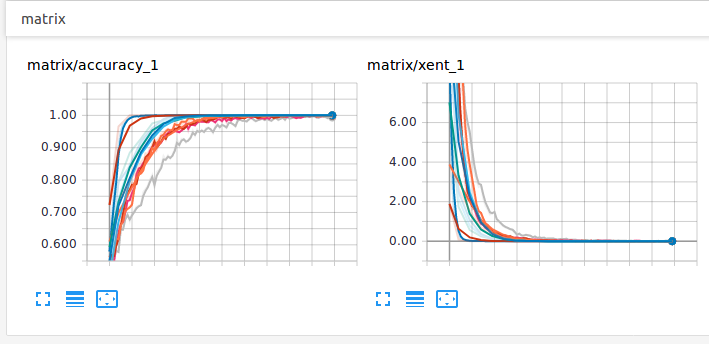

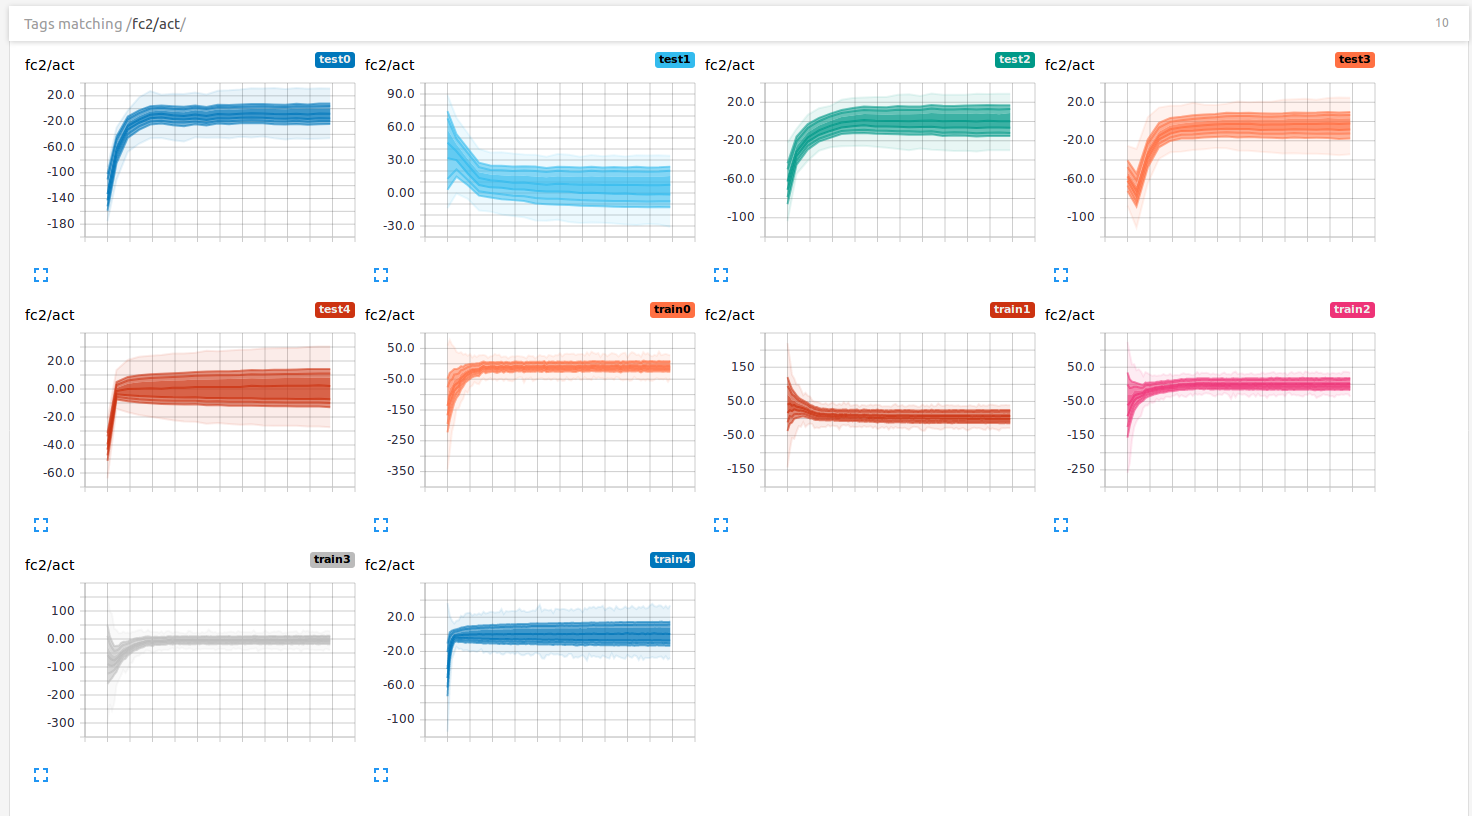

## Data 생성
**raw_data** 폴더의 image를 이용하여 학습에 사용될 데이터로 변환  
변환코드는 **data** 폴더의 **input_data** 파일 사용  

In [11]:
# Copyright kairos03 2017. All Right Reserved.

## input_data.py

import os

import numpy as np
import pandas as pd
from scipy import ndimage

In [7]:
# data path
raw_path = './raw_data'
data_path = './data'
contact_path = raw_path + '/contact'
separate_path = raw_path + '/separate'

**integrated_data_set** 함수를 이용하여 전체 데이터셋을 만듦, to_pickle을 이용하여 파일로 저장  
**read_image**는 이미지를 읽어 ndarray로 변환  
**concatenated_image**는 정면과 오른쪽 흑백 이미지를 합쳐서 (640, 512, 2)의 형태로 변환  

In [8]:
def read_image(path):
    """ Read images from path and return fnames, images"""
    print(os.listdir('.'))
    fnames = os.listdir(path)
    fnames.sort()

    imgs = []
    for name in fnames:
        img = ndimage.imread(path+name, True, 'L')
        imgs.append(img)
    return fnames, imgs


def concatenated_image(path):
    """contact front and right data"""
    # read images
    f_fnames, f_images = read_image(path + '/front/')
    r_fnames, r_images = read_image(path + '/right/')

    # reshape (330, 640, 512) to (330, 640, 512, 1)
    f_images = np.reshape(f_images, (len(f_images), 640, 512, 1))
    r_images = np.reshape(r_images, (len(r_images), 640, 512, 1))

    # concat two images (330, 640, 512, 1) to (330, 640, 512, 2)
    images = np.concatenate((f_images, r_images), 3)

    return images


def integrated_data_set(shuffle=False, to_pickle=False):
    """make Full Data set"""
    data_set = pd.DataFrame(columns=['image', 'is_contacted'])

    c_images = concatenated_image(contact_path)
    s_images = concatenated_image(separate_path)

    images = np.concatenate((c_images, s_images))

    for x in images:
        print(type(x))
        print(x)

    # images = np.transpose(images, (0, 2, 1))
    images = [x for x in images]
    print(type(images[0]))
    print(images[0])
    labels = np.concatenate((np.ones(c_images.shape[0], ), np.zeros(s_images.shape[0], )))

    data_set['image'] = images
    data_set['is_contacted'] = labels

    if shuffle:
      data_set = data_set.sample(frac=1)

    if to_pickle:
        data_set.to_pickle(data_path+'/input_data.pkl', compression='gzip')

    return data_set

**read_whole_data**를 통해 위에서 생성한 전체 Data set을 읽음  
**make_corss_validation_data_set**은 전체 Data set을 ratio를 이용하여 나눈 여러개의 Validation Data set을 생성  

여기서는 **retio=0.2**로 **5**개의 Data set을 만듦

**read_cross_validation_data_set**을 이용하여 트레이닝시 데이터를 불러오며, shuffle 파라미터를 사용하여 매 epoch시 Data set을 랜덤하게 섞어줌

In [ ]:
def read_whole_data(to_dict=False):
    data = pd.read_pickle(data_path+'/input_data.pkl', compression='gzip')

    if to_dict:
        data = data.to_dict('list')

    return data

def make_cross_validation_data_set(ratio=0.2, to_pickle=False):

    print('Make Cross Validation data set')
    data = read_whole_data()

    # separate set
    pivot = int(data.shape[0] * ratio)
    data_pair_number = int(1 / ratio)

    for i in range(data_pair_number):

        start = i * pivot
        end = (i + 1) * pivot if i+1 < data_pair_number else None
        test = data[start:end]
        train = pd.concat([data[:start], data[end:]])

        if to_pickle:
            train.to_pickle(data_path+'/train_data_{}.pkl'.format(i), compression='gzip')
            test.to_pickle(data_path+'/test_data_{}.pkl'.format(i), compression='gzip')
            print('Data set {} saved'.format(i))

    return train, test

def read_cross_validation_data_set(number, shuffle=True):
    """read corss validation data set
        Args:
            number: data set number
            shuffle: if True shuffle train data
    """
    train = pd.read_pickle(data_path+'/train_data_{}.pkl'.format(number), compression='gzip')
    test = pd.read_pickle(data_path + '/test_data_{}.pkl'.format(number), compression='gzip')

    if shuffle:
        train = train.sample(frac=1)

    train = train.to_dict('list')
    test = test.to_dict('list')
    return train, test

### 사용 예
#### 데이터 생성
```python
integrated_data_set(shuffle=True)
make_cross_validation_data_set(ratio=0.2, to_pickle=True)
```

#### 데이터 사용
```python
train, test = read_cross_validation_data_set(0, shuffle=True):
```